In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [87]:
dataset_file = 'exam_2021_02_17_data.csv'
df = pd.read_csv(dataset_file, sep='\t')

print("The dataset size is {}".format(df.shape))
df.head(5)

The dataset size is (1000, 3)


,F0,F1,F2
0,d,a,a
1,c,e,c
2,j,a,c
3,f,e,j
4,c,e,d


In [88]:
labels, counts = np.unique(df, return_counts=True)
pd.DataFrame(data=[counts], columns=labels)

,a,b,c,d,e,f,g,h,i,j
0,300,298,300,300,302,300,300,300,300,300


Let's preprocess the data using an ordinal encoder

In [89]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(dtype=float)
df0 = oe.fit_transform(df)

df = pd.DataFrame(data=df0, columns=df.columns)
df

,F0,F1,F2
0,3.0,0.0,0.0
1,2.0,4.0,2.0
2,9.0,0.0,2.0
3,5.0,4.0,9.0
4,2.0,4.0,3.0
...,...,...,...
995,3.0,6.0,6.0
996,1.0,8.0,5.0
997,8.0,6.0,6.0
998,3.0,7.0,1.0


Let's compute the size deviation index for each clust scheme. 

In [95]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score

k_range = list(range(2,20)) # set the range of k values to test 
results = []

for k_ in k_range : 
    estimator = KMeans(n_clusters=k_)
    y_pred = estimator.fit_predict(df)
    size_deviation_indedf = np.sqrt(np.unique(y_pred, return_counts=True)[1].var())/k_
    results.append([k_, silhouette_score(df, y_pred), estimator.inertia_, size_deviation_indedf])

results = pd.DataFrame(data=results, columns=['n_clusters', 'sil_score', 'inertia', 'sdi'])
results.sort_values(by='inertia', ascending=False)

,n_clusters,sil_score,inertia,sdi
0,2,0.261745,18130.828452,26.500000
1,3,0.278878,13600.277897,4.254264
2,4,0.297133,10787.098992,4.633438
3,5,0.299872,8886.393466,3.219938
4,6,0.317636,7583.953600,1.770820
5,7,0.323350,6479.479294,2.555995
6,8,0.325286,5730.518420,1.716191
7,9,0.329422,5176.453217,2.641571
8,10,0.334624,4616.754182,2.108080
9,11,0.353377,4151.860350,1.937589


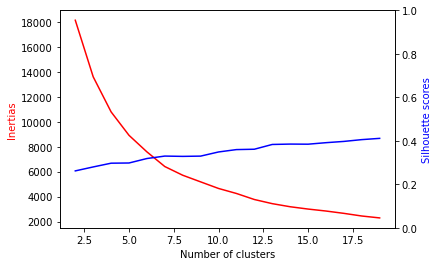

In [91]:
fig, ax = plt.subplots()
ax.plot(k_range, results['inertia'], color='red')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertias', color='red')

ax2 = ax.twinx()
ax2.plot(k_range, results['sil_score'], color='blue')
ax2.set_ylabel('Silhouette scores', color='blue')
ax2.set_ylim(0, 1)

plt.show()

I CHOOSE K = 4.
2ND METHOD CHOOSE DBSCAN.

In [93]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid

min_points = 2*df.shape[1]

param_grid = {'eps': list(np.arange(0.01, 1, 0.01)), 'min_samples': list(range(min_points-3,min_points+3,1))}
params = list(ParameterGrid(param_grid))

dbscan_out = pd.DataFrame(columns = ['eps','min_samples','n_clusts', 'silhouette', 'unclust%'])

for i in range(len(params)) : 
    db = DBSCAN(**(params[i]))
    
    y_db = db.fit_predict(df)
    cluster_labels_all = np.unique(y_db)
    n_clusters = len(cluster_labels_all[cluster_labels_all != -1])

    if n_clusters > 1:
        df_cl = df.iloc[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(df_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]

dbscan_out.sort_values(by=['unclust%']).head(10)

,eps,min_samples,n_clusts,silhouette,unclust%
0,0.01,3.0,169.0,1.0,24.1
426,0.72,3.0,169.0,1.0,24.1
252,0.43,3.0,169.0,1.0,24.1
420,0.71,3.0,169.0,1.0,24.1
132,0.23,3.0,169.0,1.0,24.1
414,0.70,3.0,169.0,1.0,24.1
138,0.24,3.0,169.0,1.0,24.1
432,0.73,3.0,169.0,1.0,24.1
408,0.69,3.0,169.0,1.0,24.1
144,0.25,3.0,169.0,1.0,24.1


Let's compare the final results

In [ ]:
from sklearn.metrics import pair_confusion_matrix
from sklearn.metrics import adjusted_rand_score

k = 4

db = DBSCAN(**(params[i]))
y_db = db.fit_predict(df)

estimator = KMeans(n_clusters=k)
y_pred = estimator.fit_predict(df)
